# Downscaling Temperature at 2m for **NYC Tristate** area

**Variables:**
* Variable to be downscaled: Temperature at 2 meters (T2)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 115,291.16 km²

# Instructions

Once all the necessary libraries have been installed into your virtual enviornment we can begin to run the downscaling model. In the "Define paths ..." section, please update the paths to the data files.

# Import libraries

In [14]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [15]:
!python --version
#Should be Python 3.8.18

Python 3.8.18


# Define paths and retrieve files from server

These files include both T2 and PSFC variables. If we want to run the model without a predictor variable, make sure ```predictors_train=None, predictors_val=None, predictors_test=None``` when training the model. 

In [16]:
uwrf_train = xr.open_dataset('/home/gvaillant1/data/T2-tristate-data/uWRF/uWRF_train_tristate_01-02.nc') #**change**
uwrf_val = xr.open_dataset('/home/gvaillant1/data/T2-tristate-data/uWRF/uWRF_val_tristate_03.nc') #**change**
uwrf_test = xr.open_dataset('/home/gvaillant1/data/T2-tristate-data/uWRF/uWRF_test_tristate_03.nc') #**change**

nam_train = xr.open_dataset('/home/gvaillant1/data/T2-tristate-data/NAM/nam_train_tristate_01-02.nc') #**change**
nam_val = xr.open_dataset('/home/gvaillant1/data/T2-tristate-data/NAM/nam_val_tristate_03.nc') #**change**
nam_test = xr.open_dataset('/home/gvaillant1/data/T2-tristate-data/NAM/nam_test_tristate_03.nc') #**change**

# Calculating spatial coverage **(Ignore for now because it can cause the kernel to die)**

# Define variables

In [17]:
#High resolution (uWRF) data
T2_hr_train = uwrf_train.T2
T2_hr_val = uwrf_val.T2
T2_hr_test = uwrf_test.T2

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC
#--------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2
T2_lr_val = nam_val.T2
T2_lr_test = nam_test.T2

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Scale the data

In [18]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)

# Compare original resolutions

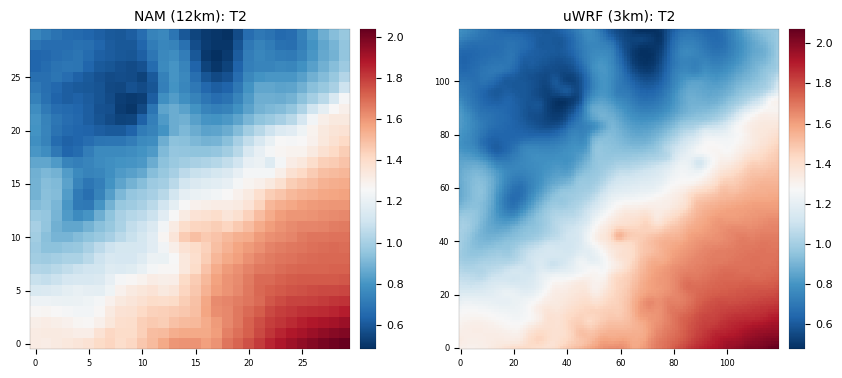

In [19]:
#T2: Temperature at 2 meters
ecv.plot((x_train[0].values, y_train[0]), subplot_titles=('NAM (12km): T2', 'uWRF (3km): T2'))

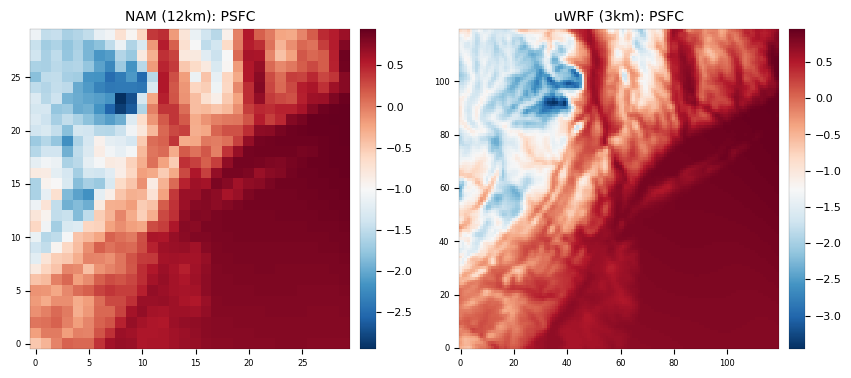

In [20]:
#PSFC: Surface Pressure
ecv.plot((x_z_train[0].values, y_z_train[0]), subplot_titles=('NAM (12km): PSFC', 'uWRF (3km): PSFC'))

# Add channel dimension

In [21]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

# Verify shape

In [22]:
print("T2 hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("T2 lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

T2 hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

PSFC hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

T2 lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)

PSFC lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)


# Example coarsening method occuring during training:

For this model, we do not use the LR data (NAM) during training. Instead, we use a coarsened version (via interpolation) of the HR (uWRF) T2 and PSFC data. The DL4DS model carries out this interpolation on the fly by using the helper function dds.create_pair_hr_lr() (not to be called by the user). This process is done **automatically** inside the training loop (by calling one of the two (Supervised vs GAN) Trainer classes in DL4DS), which we examplify here with the spc upsampling. 

HR array: (120, 120, 1), LR array (30, 30, 2)


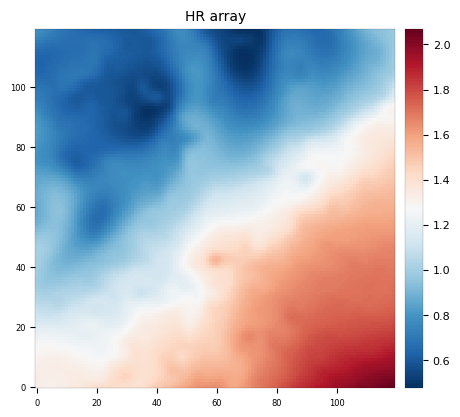

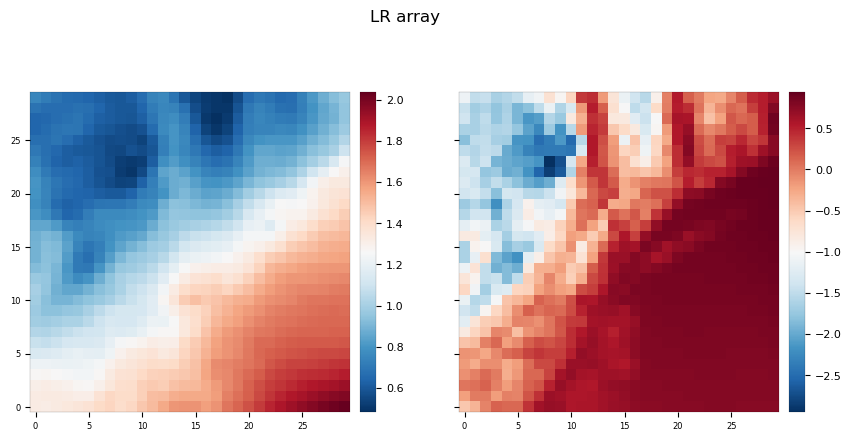

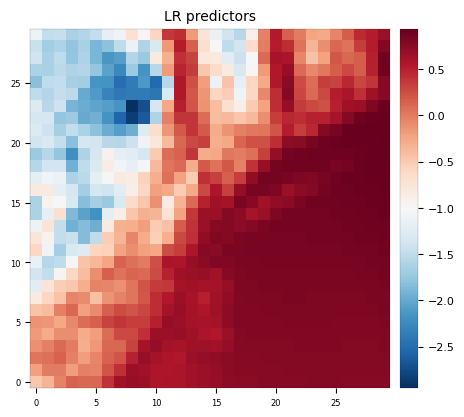

In [23]:
df = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

# Training Model

## !! **HERE WE NEED TO CHANGE THE PATHS** !!

Tuning hyperparameters:

* filters
* blocks
* filter size: Cannot change
* stride: Cannot change
* padding: Cannot change
* learning rate
* batch size
* upsampling
* epochs
* learning rate

Possible backbones:

* resnet
* densenet
* convnet
* convnext

Running model with backbone=resnet, filters=4, blocks=1, epochs=3
List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
Checking if model has already been tested: ('T2', 'NULL', 'resnet', '4', '1', '(0.001, 0.0001)', 'inter_area', 'spc', '3', 'mae', 'False')
--------------------------------------------------------------------------------
Starting time: 2025-02-21 12:22:46
--------------------------------------------------------------------------------
Model: "resnet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_2 (InputLayer)                        [(None, None, None, 1)]                      0              []                                          

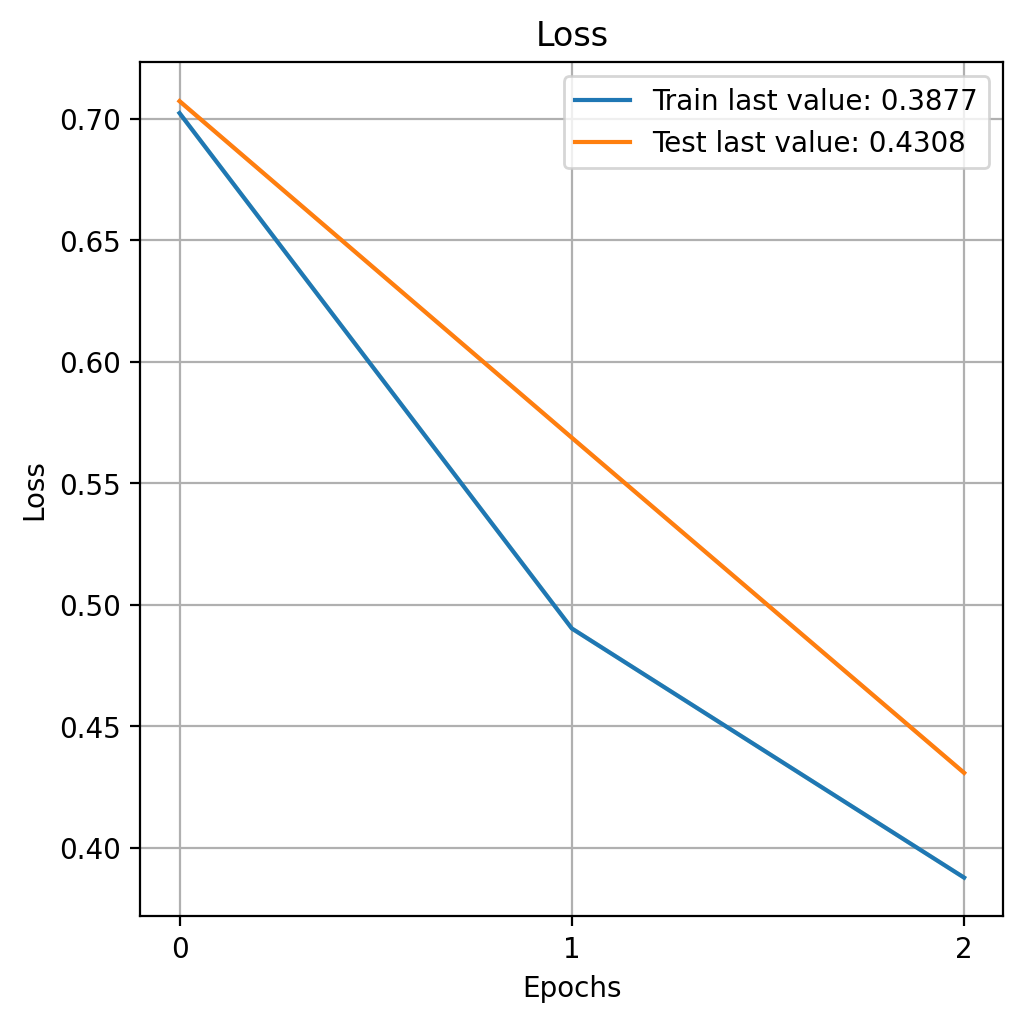

Moved to best model directory
Running model with backbone=densenet, filters=4, blocks=1, epochs=3
List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
Checking if model has already been tested: ('T2', 'NULL', 'densenet', '4', '1', '(0.001, 0.0001)', 'inter_area', 'spc', '3', 'mae', 'False')
--------------------------------------------------------------------------------
Starting time: 2025-02-21 12:23:13
--------------------------------------------------------------------------------
Model: "densenet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_3 (InputLayer)                        [(None, None, None, 1)]                      0              []      

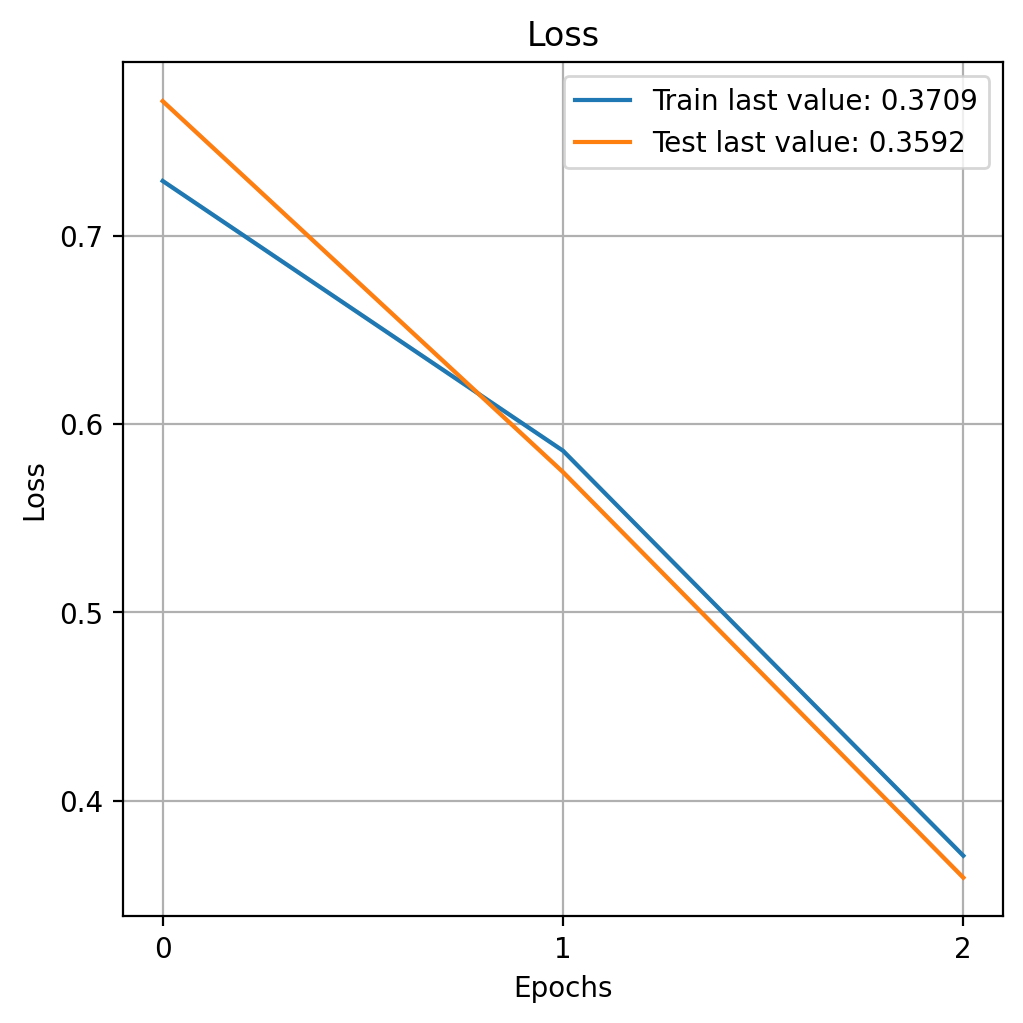

Moved to best model directory
Training complete


In [24]:
import os
import shutil
import csv

#------------------------------------------------------------------------------------
results = []
best_loss = float('inf')
best_model_path = "/home/gvaillant1/downscaling/pretrained-models/T2-Tristate-Best-Model" #**change**
other_models_path = "/home/gvaillant1/downscaling/pretrained-models/T2-Tristate-Other-Models" #**change**
test_loss_file = os.path.join(other_models_path, "test_loss.txt")
runtime_file = os.path.join(other_models_path, "running_time.txt")
csv_file = "/home/gvaillant1/downscaling/results/model_results.csv" #**change**

#------------------------------------------------------------------------------------
#TESTING DIFFERENT HYPER PARAMETERS:
#change the hyperparams to test different models
backbones = ['resnet', 'densenet']
num_filters = [16, 32] 
num_blocks = [8, 16]
epochs = [25, 50, 100]
lrate = (1e-3, 1e-4)
#------------------------------------------------------------------------------------

#Check the existing results csv file to see if the parameter combination has already been tested
existing_results = []
if os.path.exists(csv_file):
    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        next(reader, None)  # Skip header
        for row in reader:
            existing_results.append(tuple(row))

# Retrieve the lowest loss from CSV before training
if existing_results:
    best_loss = min(float(row[2]) for row in existing_results if row[2] != "NULL")

for backbone in backbones:
    for filters in num_filters:
        for blocks in num_blocks:
            for epoch in epochs:
                ARCH_PARAMS = dict(n_filters=filters,
                                   n_blocks=blocks,
                                   normalization=None,
                                   dropout_rate=0.5,
                                   dropout_variant='spatial',
                                   attention=False,
                                   activation='relu',
                                   localcon_layer=False)
    
                print(f"Running model with backbone={backbone}, filters={filters}, blocks={blocks}, epochs={epoch}")
    
                trainer = dds.SupervisedTrainer(
                    backbone=backbone,
                    upsampling='spc',
                    data_train=y_train,
                    data_val=y_val,
                    data_test=y_test,
                    data_train_lr=None,
                    data_val_lr=None,
                    data_test_lr=None,
                    scale=4,
                    time_window=None,
                    static_vars=None,
                    predictors_train=None, #Add predictor information here (not required)
                    predictors_val=None, #Add predictor information here (not required)
                    predictors_test=None, #Add predictor informatio here (not required)
                    interpolation='inter_area',
                    patch_size=None,
                    batch_size=60,
                    loss='mae',
                    epochs=epoch,
                    steps_per_epoch=None,
                    validation_steps=None,
                    test_steps=None,
                    learning_rate=lrate,
                    lr_decay_after=1e4,
                    early_stopping=False,
                    patience=6,
                    min_delta=0,
                    save=True,
                    save_bestmodel=True,
                    save_path=other_models_path,
                    show_plot=True,
                    verbose=True,
                    device='CPU',
                    **ARCH_PARAMS)
    
                # Create unique model identifier (ensure all fields match CSV format)
                #Needed to specify the datatypes so the code will be able to correctly check if we have done the model before
                model_id = (str(y_train.name), "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                            backbone, str(filters), str(blocks), str(lrate), trainer.interpolation, trainer.upsampling, 
                            str(trainer.epochs), trainer.loss, str(trainer.early_stopping))
    
                model_id = (
                    str(y_train.name),
                    "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                    backbone,
                    str(filters),
                    str(blocks),
                    str(lrate),
                    trainer.interpolation,
                    trainer.upsampling,
                    str(trainer.epochs),
                    trainer.loss,
                    str(trainer.early_stopping)
                )
    
                print(f"Checking if model has already been tested: {model_id}")
    
                #Check if model already exists in CSV
                model_exists = False
                for row in existing_results:
                    existing_model_id = (row[0], row[1], row[3], row[4], row[5], row[11], 
                                         row[9], row[8], row[6], row[12], row[13])
                    #print(f"Comparing with existing model: {existing_model_id}")
                    
                    if existing_model_id == model_id:
                        print("Match found! Skipping training for:", model_id)
                        model_exists = True
                        break
                
                if model_exists:
                    continue
    
                trainer.run()
    
                if os.path.exists(test_loss_file):
                    with open(test_loss_file, "r") as f:
                        val_loss = float(f.read().strip())
                else:
                    val_loss = float('inf')
    
                if os.path.exists(runtime_file):
                    with open(runtime_file, "r") as f:
                        training_runtime = f.read().strip()
                else:
                    training_runtime = "NULL"

                model_save_path = other_models_path  # Default save path

                #Check if the loss we just calculated is the lowest
                #If so, it is the best model and it should be put in the best model directory
                if val_loss < best_loss:
                    best_loss = val_loss

                    # Remove previous best model completely before replacing it
                    if os.path.exists(best_model_path):
                        shutil.rmtree(best_model_path)  # Delete the entire directory
    
                    # Move new best model to the best model directory
                    shutil.move(other_models_path, best_model_path)
                    model_save_path = best_model_path #replace the model_save_path with the best model path if it has a lower loss
                    print('Moved to best model directory')
    
                results.append((str(y_train.name), "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                                val_loss, backbone, filters, blocks, trainer.epochs, 
                                trainer.model.count_params(), trainer.upsampling, trainer.interpolation, 
                                trainer.batch_size, lrate, trainer.loss, trainer.early_stopping, 
                                training_runtime, model_save_path))
    
                #Write the information about the model and results in the results CSV file
                file_exists = os.path.isfile(csv_file)
                with open(csv_file, mode='a', newline='') as f:
                    writer = csv.writer(f)
                    if not file_exists:
                        writer.writerow(["Downscaled Variable", "Predictor", "Test Loss",
                                         "Backbone", "Filters", "Blocks",
                                        "Epochs", "Parameters", "Upsampling Method",
                                         "Interpolation Method", "Batch Size", "Learning Rate",
                                        "Loss Function", "Early Stopping", "Training Runtime", "Model Path"])
                    writer.writerow([str(y_train.name), "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                                     val_loss, backbone, filters, blocks,
                                     trainer.epochs, trainer.model.count_params(), trainer.upsampling,
                                     trainer.interpolation, trainer.batch_size, lrate, 
                                     trainer.loss, trainer.early_stopping, training_runtime, model_save_path])

print("Training complete")


# Inference on uWRF test set

In [25]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=64,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-02-21 12:23:50
--------------------------------------------------------------------------------
14/14 [==============================] - 1s 60ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:01.318001
--------------------------------------------------------------------------------


# Inference on NAM

In [26]:
pred1 = dds.Predictor(
    trainer, 
    x_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-02-21 12:23:52
--------------------------------------------------------------------------------
385/385 [==============================] - 3s 8ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:03.840698
--------------------------------------------------------------------------------


# Inference on unseen NAM (may data) **IGNORE FOR NOW**
May uwrf data was not seen during training at all. So we will feed the model May NAM data and see how it performs.

# Comparing predictions on uWRF test set

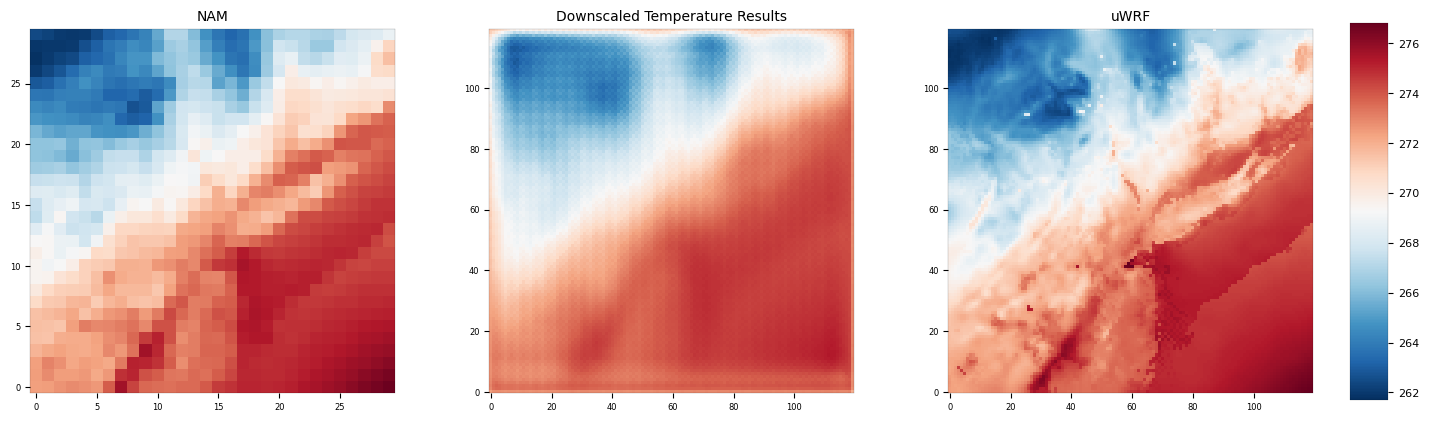

MAE for test set: 0.7098111510276794


In [27]:
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_x_test[1].values, unscaled_y_pred[1], unscaled_y_test[1].values),
         share_colorbar=True, share_dynamic_range=True, show_coastline=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

mae = dds.losses.mae(unscaled_y_test[0].values, unscaled_y_pred[0])
print(f"MAE for test set: {mae}")

# Comparing predictions on NAM data 

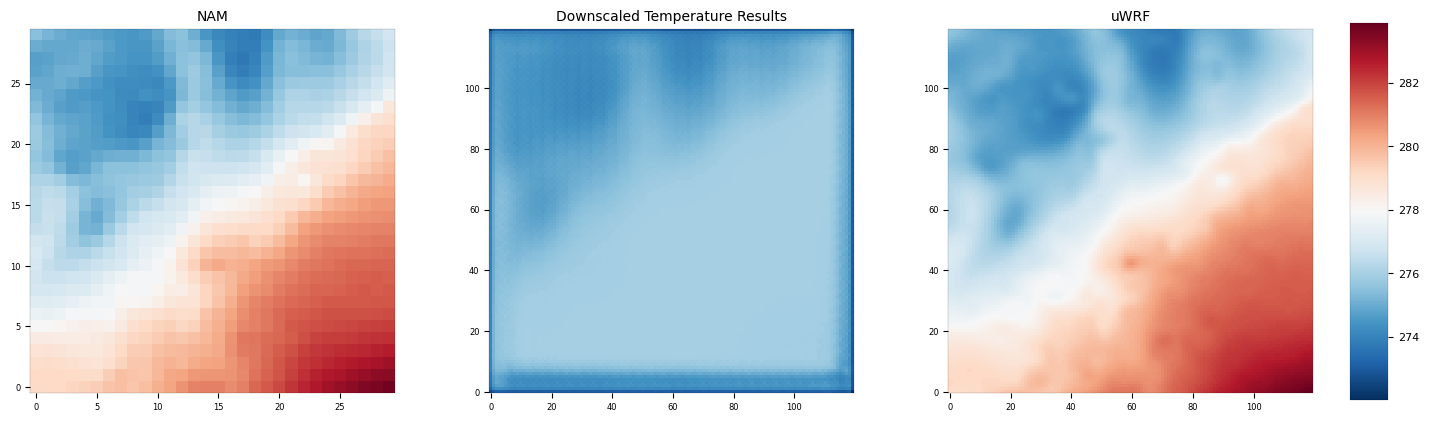

In [28]:
unscaled_x_train = T2_scaler_train.inverse_transform(x_train)
unscaled_y_train = T2_scaler_train.inverse_transform(y_train)
ecv.plot((unscaled_x_train[0].values, unscaled_x_pred[0], unscaled_y_train[0].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

# Loss calculations

In [29]:
mae = dds.losses.mae(unscaled_y_test.values[1], unscaled_y_pred[1])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")



MAE for training: 0.8954343199729919
MSE for training: 1.3998204469680786

MAE on NAM: 5.084623336791992
MSE on NAM: 35.43024444580078

MAE loss is not the same
MSE loss is not the same
MAE between predictions, to see if they're exactly the same:
MAE: 4.496290683746338
